In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import random
import time
from datetime import datetime
import json
from tqdm import tqdm
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import plotly.express as px
import os
import random
import glob
import kagglehub
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)
random.seed(42)
print("Basic libraries imported successfully!")


e:\Code\Alzheimer-Disease-Diagnosis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Basic libraries imported successfully!


In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ninadaithal/imagesoasis")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\sajib\.cache\kagglehub\datasets\ninadaithal\imagesoasis\versions\1


In [17]:
# Resolve dataset path from KaggleHub `path`
expected_classes = ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']

# Prefer .../versions/1/Data if present, else the root path
candidates = [
    os.path.join(path, 'Data'),
    path
]

dataset_path = None
found_classes = []
for cand in candidates:
    if os.path.isdir(cand):
        subdirs = [d for d in os.listdir(cand) if os.path.isdir(os.path.join(cand, d))]
        if any(cls in subdirs for cls in expected_classes):
            dataset_path = cand
            found_classes = [d for d in subdirs if d in expected_classes]
            break

if dataset_path:
    print(f"Using dataset path: {dataset_path}")
    print(f"Classes found: {found_classes}")
    class_counts = {}
    total_images = 0
    for class_name in found_classes:
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(image_files)
        total_images += len(image_files)
    print(f"Total images: {total_images}")
else:
    print("Could not resolve dataset path automatically. Please verify the download and directory structure.")


Using dataset path: C:\Users\sajib\.cache\kagglehub\datasets\ninadaithal\imagesoasis\versions\1\Data
Classes found: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Total images: 86437


In [18]:
def find_dataset_path():
    """Automatically find the OASIS dataset path"""
    possible_paths = [
        'C:/Users/sajib/OneDrive/Desktop/Alzheimer-Disease-Diagnosis/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1',
        'Data',
        './Data',
        '../Data'
    ]
    
    expected_classes = ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']
    
    for path in possible_paths:
        if os.path.exists(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if any(cls in subdirs for cls in expected_classes):
                return path, subdirs
    
    return None, []
dataset_path, found_classes = find_dataset_path()

if dataset_path:
    print(f" Dataset found at: {dataset_path}")
    print(f" Classes found: {found_classes}")
    
    total_images = 0
    class_counts = {}
    
    for class_name in found_classes:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(image_files)
            class_counts[class_name] = count
            total_images += count
            print(f"   {class_name}: {count:,} images")
    
    print(f"Total images: {total_images:,}")
else:
    print("Dataset not found! Please ensure the OASIS dataset is downloaded.")


Dataset not found! Please ensure the OASIS dataset is downloaded.


In [ ]:
def find_dataset_path():
    """Automatically find the OASIS dataset path"""
    possible_paths = [
        'C:/Users/sajib/OneDrive/Desktop/Alzheimer-Disease-Diagnosis/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1',
        'Data',
        './Data',
        '../Data'
    ]
    
    expected_classes = ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']
    
    for path in possible_paths:
        if os.path.exists(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if any(cls in subdirs for cls in expected_classes):
                return path, subdirs
    
    return None, []
dataset_path, found_classes = find_dataset_path()

if dataset_path:
    print(f" Dataset found at: {dataset_path}")
    print(f" Classes found: {found_classes}")
    
    total_images = 0
    class_counts = {}
    
    for class_name in found_classes:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(image_files)
            class_counts[class_name] = count
            total_images += count
            print(f"   {class_name}: {count:,} images")
    
    print(f"Total images: {total_images:,}")
else:
    print("Dataset not found! Please ensure the OASIS dataset is downloaded.")


Dataset not found! Please ensure the OASIS dataset is downloaded.


In [ ]:
def find_dataset_path():
    """Automatically find the OASIS dataset path"""
    possible_paths = [
        'C:/Users/sajib/OneDrive/Desktop/Alzheimer-Disease-Diagnosis/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1',
        'Data',
        './Data',
        '../Data'
    ]
    
    expected_classes = ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']
    
    for path in possible_paths:
        if os.path.exists(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if any(cls in subdirs for cls in expected_classes):
                return path, subdirs
    
    return None, []
dataset_path, found_classes = find_dataset_path()

if dataset_path:
    print(f" Dataset found at: {dataset_path}")
    print(f" Classes found: {found_classes}")
    
    total_images = 0
    class_counts = {}
    
    for class_name in found_classes:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(image_files)
            class_counts[class_name] = count
            total_images += count
            print(f"   {class_name}: {count:,} images")
    
    print(f"Total images: {total_images:,}")
else:
    print("Dataset not found! Please ensure the OASIS dataset is downloaded.")


Dataset not found! Please ensure the OASIS dataset is downloaded.


In [ ]:
def find_dataset_path():
    """Automatically find the OASIS dataset path"""
    possible_paths = [
        'C:/Users/sajib/OneDrive/Desktop/Alzheimer-Disease-Diagnosis/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1',
        'Data',
        './Data',
        '../Data'
    ]
    
    expected_classes = ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']
    
    for path in possible_paths:
        if os.path.exists(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if any(cls in subdirs for cls in expected_classes):
                return path, subdirs
    
    return None, []
dataset_path, found_classes = find_dataset_path()

if dataset_path:
    print(f" Dataset found at: {dataset_path}")
    print(f" Classes found: {found_classes}")
    
    total_images = 0
    class_counts = {}
    
    for class_name in found_classes:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(image_files)
            class_counts[class_name] = count
            total_images += count
            print(f"   {class_name}: {count:,} images")
    
    print(f"Total images: {total_images:,}")
else:
    print("Dataset not found! Please ensure the OASIS dataset is downloaded.")


Dataset not found! Please ensure the OASIS dataset is downloaded.


In [22]:
def find_dataset_path():
    """Automatically find the OASIS dataset path"""
    possible_paths = [
        'C:/Users/sajib/OneDrive/Desktop/Alzheimer-Disease-Diagnosis/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data',
        '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1',
        'Data',
        './Data',
        '../Data'
    ]
    
    expected_classes = ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']
    
    for path in possible_paths:
        if os.path.exists(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if any(cls in subdirs for cls in expected_classes):
                return path, subdirs
    
    return None, []
dataset_path, found_classes = find_dataset_path()

if dataset_path:
    print(f" Dataset found at: {dataset_path}")
    print(f" Classes found: {found_classes}")
    
    total_images = 0
    class_counts = {}
    
    for class_name in found_classes:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(image_files)
            class_counts[class_name] = count
            total_images += count
            print(f"   {class_name}: {count:,} images")
    
    print(f"Total images: {total_images:,}")
else:
    print("Dataset not found! Please ensure the OASIS dataset is downloaded.")


Dataset not found! Please ensure the OASIS dataset is downloaded.


In [23]:

if dataset_path and class_counts:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    bars = ax1.bar(classes, counts, color=colors)
    ax1.set_title('Alzheimer MRI Dataset - Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Dementia Severity')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    ax2.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90, colors=colors)
    ax2.set_title('Class Proportions', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    print(f"Dataset Statistics:")
    print(f"{'='*50}")
    print(f"Total images: {sum(counts):,}")
    print(f"Number of classes: {len(classes)}")
    print(f"Average images per class: {np.mean(counts):,.0f}")
    print(f"Std deviation: {np.std(counts):,.0f}")
    print(f"Min images in a class: {min(counts):,}")
    print(f"Max images in a class: {max(counts):,}")
    
    imbalance_ratio = max(counts) / min(counts)
    print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 5:
        print(" Significant class imbalance detected - will use weighted loss for training")
    else:
        print("Moderate class imbalance - manageable with weighted loss for training")
else:
    print("Cannot visualize - dataset not found")


Cannot visualize - dataset not found


In [ ]:

possible_paths = [
    '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data',
    '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1',
    'Data',
    './Data',
    '../Data'
]

dataset_path = None
for path in possible_paths:
    if os.path.exists(path):
        subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
        expected_classes = ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']
        
        if any(cls in subdirs for cls in expected_classes):
            dataset_path = path
            print(f"Dataset found at: {dataset_path}")
            print(f"Subdirectories: {subdirs}")
            break

if dataset_path is None:
    print("Dataset not found automatically. Please update the dataset_path variable manually.")
    print("Expected structure:")
    print("Data/")
    print("  Mild Dementia/")
    print("  Very mild Dementia/")
    print("  Moderate Dementia/")
    print("  Non Demented/")
else:
    print(f"Using dataset path: {dataset_path}")


In [ ]:

def explore_dataset(dataset_path):
    """Explore the dataset and return information about classes and image counts"""
    
    if dataset_path is None:
        print("Please set the correct dataset_path in the previous cell")
        return None
    
    class_names = [d for d in os.listdir(dataset_path) 
                   if os.path.isdir(os.path.join(dataset_path, d))]
    
    print(f"Found {len(class_names)} classes:")
    
    class_info = {}
    total_images = 0
    
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        class_info[class_name] = {
            'count': len(image_files),
            'sample_files': image_files[:3] 
        }
        total_images += len(image_files)
        
        print(f"  {class_name}: {len(image_files)} images")
        print(f"    Sample files: {image_files[:3]}")
    
    print(f"\nTotal images: {total_images}")
    
    return {
        'class_names': class_names,
        'class_info': class_info,
        'total_images': total_images,
        'dataset_path': dataset_path
    }


dataset_info = explore_dataset(dataset_path)


In [ ]:

if dataset_info is not None:
    class_names = dataset_info['class_names']
    class_counts = [dataset_info['class_info'][name]['count'] for name in class_names]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    bars = ax1.bar(class_names, class_counts, color=['skyblue', 'lightgreen', 'orange', 'salmon'])
    ax1.set_title('Number of Images per Class', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars, class_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    
    ax2.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140,
            colors=['skyblue', 'lightgreen', 'orange', 'salmon'])
    ax2.set_title('Class Proportions', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Dataset Statistics:")
    print(f"Total images: {sum(class_counts):,}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Average images per class: {np.mean(class_counts):.1f}")
    print(f"Min images in a class: {min(class_counts)}")
    print(f"Max images in a class: {max(class_counts)}")
    
    imbalance_ratio = max(class_counts) / min(class_counts)
    print(f"Class imbalance ratio: {imbalance_ratio:.2f}")
else:
    print("Please fix the dataset path issue first.")


In [ ]:


def display_sample_images(dataset_info, samples_per_class=3):
    if dataset_info is None:
        print("Dataset info not available")
        return
    
    class_names = dataset_info['class_names']
    dataset_path = dataset_info['dataset_path']
    
    fig, axes = plt.subplots(len(class_names), samples_per_class, 
                            figsize=(samples_per_class * 4, len(class_names) * 3))
    
    if len(class_names) == 1:
        axes = axes.reshape(1, -1)
    
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        sample_files = random.sample(image_files, min(samples_per_class, len(image_files)))
        
        for j, img_file in enumerate(sample_files):
            img_path = os.path.join(class_dir, img_file)
            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img, cmap='gray')
                axes[i, j].set_title(f"{class_name}\\n{img_file}", fontsize=10)
                axes[i, j].axis('off')
            except Exception as e:
                axes[i, j].text(0.5, 0.5, f"Error loading\\n{img_file}", 
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

if dataset_info is not None:
    print("Sample images from each class:")
    display_sample_images(dataset_info, samples_per_class=4)
else:
    print("Please fix the dataset path first.")


In [ ]:
def analyze_image_properties(dataset_info, sample_size=100):
    """Analyze image properties like size, format, etc."""
    
    if dataset_info is None:
        print("Dataset info not available")
        return None
    
    class_names = dataset_info['class_names']
    dataset_path = dataset_info['dataset_path']
    
    image_properties = []
    
    print("Analyzing image properties...")
    
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        sample_files = random.sample(image_files, min(sample_size, len(image_files)))
        
        for img_file in sample_files:
            img_path = os.path.join(class_dir, img_file)
            try:
                with Image.open(img_path) as img:
                    properties = {
                        'class': class_name,
                        'filename': img_file,
                        'width': img.width,
                        'height': img.height,
                        'mode': img.mode,
                        'format': img.format
                    }
                    image_properties.append(properties)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    df = pd.DataFrame(image_properties)
    
    print(f"\\nAnalyzed {len(df)} images")
    print(f"Image formats found: {df['format'].unique()}")
    print(f"Image modes found: {df['mode'].unique()}")
    
    print(f"\\nImage size statistics:")
    print(f"Width - Min: {df['width'].min()}, Max: {df['width'].max()}, Mean: {df['width'].mean():.1f}")
    print(f"Height - Min: {df['height'].min()}, Max: {df['height'].max()}, Mean: {df['height'].mean():.1f}")
    
    return df

if dataset_info is not None:
    image_props_df = analyze_image_properties(dataset_info, sample_size=50)
else:
    print("Please fix the dataset path first.")


In [ ]:

if 'image_props_df' in locals() and image_props_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for class_name in image_props_df['class'].unique():
        class_data = image_props_df[image_props_df['class'] == class_name]
        axes[0, 0].hist(class_data['width'], alpha=0.7, label=class_name, bins=20)
    axes[0, 0].set_title('Image Width Distribution by Class')
    axes[0, 0].set_xlabel('Width (pixels)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    
    for class_name in image_props_df['class'].unique():
        class_data = image_props_df[image_props_df['class'] == class_name]
        axes[0, 1].hist(class_data['height'], alpha=0.7, label=class_name, bins=20)
    axes[0, 1].set_title('Image Height Distribution by Class')
    axes[0, 1].set_xlabel('Height (pixels)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    
    sns.boxplot(data=image_props_df, x='class', y='width', ax=axes[1, 0])
    axes[1, 0].set_title('Width Distribution by Class (Boxplot)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=image_props_df, x='class', y='height', ax=axes[1, 1])
    axes[1, 1].set_title('Height Distribution by Class (Boxplot)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    unique_sizes = image_props_df[['width', 'height']].drop_duplicates()
    print(f"Number of unique image sizes: {len(unique_sizes)}")
    if len(unique_sizes) <= 5:
        print("Most common image sizes:")
        size_counts = image_props_df.groupby(['width', 'height']).size().sort_values(ascending=False)
        print(size_counts.head())
    else:
        print("Images have varying sizes - resizing will be needed for model training")
else:
    print("Image properties data not available")


Path to dataset files: C:\Users\sajib\.cache\kagglehub\datasets\ninadaithal\imagesoasis\versions\1


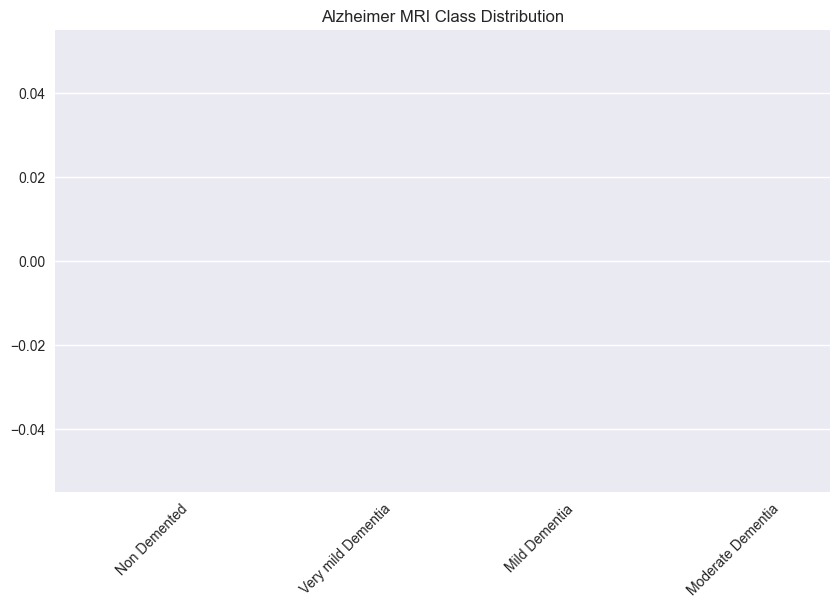

In [24]:
path = kagglehub.dataset_download("ninadaithal/imagesoasis")

print("Path to dataset files:", path)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
dataset_path = "/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data"

classes = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
class_counts = {cls: len(glob.glob(f"{dataset_path}/{cls}/*.jpg")) for cls in classes}

plt.figure(figsize=(10,6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Alzheimer MRI Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:


dimension_counts = {cls: {} for cls in classes}

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    image_files = glob.glob(os.path.join(cls_path, '*.jpg'))
    
    for img_file in image_files:
        with Image.open(img_file) as img:
            dimensions = img.size  
            if dimensions in dimension_counts[cls]:
                dimension_counts[cls][dimensions] += 1
            else:
                dimension_counts[cls][dimensions] = 1


x_labels = list(classes)
x_pos = np.arange(len(x_labels))
y_labels = set()
for cls in classes:
    y_labels.update(dimension_counts[cls].keys())
y_labels = sorted(y_labels)
y_pos = np.arange(len(y_labels))

x, y = np.meshgrid(x_pos, y_pos)
z = np.zeros_like(x)


for i, cls in enumerate(classes):
    for j, dim in enumerate(y_labels):
        z[j, i] = dimension_counts[cls].get(dim, 0)


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


dx = dy = 0.5
dz = z.flatten()
ax.bar3d(x.flatten(), y.flatten(), np.zeros_like(dz), dx, dy, dz, shade=True)


ax.set_xlabel('Class')
ax.set_ylabel('Image Dimensions (Width x Height)')
ax.set_zlabel('Count')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticks(y_pos)
ax.set_yticklabels([f'{dim[0]}x{dim[1]}' for dim in y_labels], rotation=45, ha='right')

plt.title('3D Bar Chart: Count vs Class vs Image Dimensions')
plt.tight_layout()
plt.show()

In [ ]:
class_data = {
    'Class': list(class_counts.keys()),
    'Count': list(class_counts.values())
}

df_class = pd.DataFrame(class_data)

fig = px.treemap(
    df_class,
    path=['Class'],
    values='Count',
    title='Treemap: Class Proportions',
    color='Class',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.show()

Classes found: ['Data']
Data: 0 images


IndexError: list index out of range

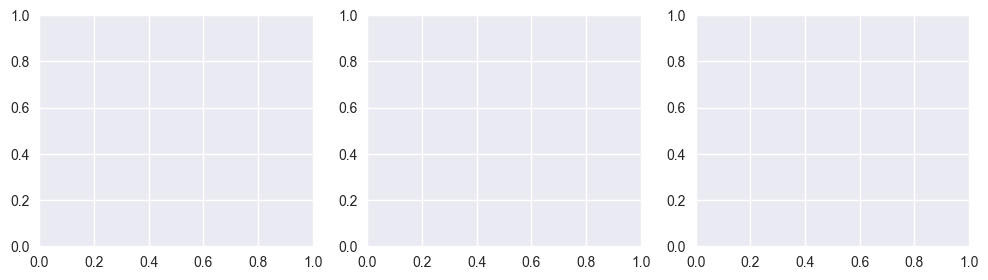

In [27]:
dataset_path = "C:/Users/sajib/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1"

class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Classes found:", class_names)


for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    num_images = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])
    print(f"{class_name}: {num_images} images")

fig, axes = plt.subplots(len(class_names), 3, figsize=(12, 3 * len(class_names)))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
    for j in range(3):
        img_path = os.path.join(class_dir, image_files[j])
        img = Image.open(img_path)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(f"{class_name}\n{image_files[j]}")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:


image_shapes = []
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    for fname in os.listdir(class_dir):
        if fname.endswith('.jpg'):
            img = Image.open(os.path.join(class_dir, fname))
            image_shapes.append(img.size)


widths, heights = zip(*image_shapes)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=20, color='orange')
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')
plt.subplot(1,2,2)
plt.hist(heights, bins=20, color='green')
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    pixels = []
    for fname in os.listdir(class_dir)[:10]:  
        img = Image.open(os.path.join(class_dir, fname)).convert('L')
        pixels.extend(np.array(img).flatten())
    plt.hist(pixels, bins=50, alpha=0.5, label=class_name)
plt.title('Pixel Intensity Distribution by Class')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [29]:

class AlzheimerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        self.class_to_idx = {
            'Non Demented': 0,
            'Very mild Dementia': 1,
            'Mild Dementia': 2,
            'Moderate Dementia': 3
        }
        
        if len(self.labels) > 0 and isinstance(self.labels[0], str):
            self.labels = [self.class_to_idx[label] for label in self.labels]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')  # keep grayscale; transforms will expand to 3ch
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def get_transforms(img_size=224, is_training=False):
    """Medical-safe transforms; avoid color/hue changes; keep geometry modest; ensure 3-channel grayscale"""
    if is_training:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.Grayscale(num_output_channels=3),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

print(" Dataset class and transforms defined successfully!")


 Dataset class and transforms defined successfully!


In [30]:

def load_and_split_data(dataset_path, class_names, test_size=0.15, val_size=0.15, random_state=42):
    """Load dataset and create train/val/test splits (70-15-15)"""
    
    image_paths = []
    labels = []
    
    print(f" Loading data from {len(class_names)} classes...")
    
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_dir):
            continue
            
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_file in image_files:
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_name)
    
    print(f" Total images loaded: {len(image_paths):,}")
    
    class_dist = Counter(labels)
    for class_name, count in class_dist.items():
        print(f"   {class_name}: {count:,} images ({count/len(labels)*100:.1f}%)")
    
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, 
        test_size=test_size, 
        stratify=labels, 
        random_state=random_state
    )
    
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, 
        test_size=val_size_adjusted, 
        stratify=y_temp, 
        random_state=random_state
    )
    
    print(f"\\n Dataset split completed:")
    print(f"   Train: {len(X_train):,} images ({len(X_train)/len(image_paths)*100:.1f}%)")
    print(f"   Validation: {len(X_val):,} images ({len(X_val)/len(image_paths)*100:.1f}%)")
    print(f"   Test: {len(X_test):,} images ({len(X_test)/len(image_paths)*100:.1f}%)")
    
    return {
        'train': {'paths': X_train, 'labels': y_train},
        'val': {'paths': X_val, 'labels': y_val},
        'test': {'paths': X_test, 'labels': y_test},
        'class_names': class_names,
        'class_counts': class_dist
    }

def create_data_loaders(data_splits, batch_size=32, img_size=224, num_workers=0):
    """Create data loaders (num_workers=0 to avoid multiprocessing issues)"""

    train_transform = get_transforms(img_size=img_size, is_training=True)
    val_transform = get_transforms(img_size=img_size, is_training=False)

    train_dataset = AlzheimerDataset(
        data_splits['train']['paths'],
        data_splits['train']['labels'],
        transform=train_transform
    )

    val_dataset = AlzheimerDataset(
        data_splits['val']['paths'],
        data_splits['val']['labels'],
        transform=val_transform
    )

    test_dataset = AlzheimerDataset(
        data_splits['test']['paths'],
        data_splits['test']['labels'],
        transform=val_transform
    )

    # Robust class weights aligned with number of classes
    num_classes = 4
    train_label_tensor = torch.tensor(train_dataset.labels, dtype=torch.long)
    class_counts = torch.bincount(train_label_tensor, minlength=num_classes).float()
    class_counts[class_counts == 0] = 1.0
    weights = (class_counts.sum() / (num_classes * class_counts)).numpy()
    class_weights = torch.tensor(weights, dtype=torch.float)

    print(f" Class weights: {class_weights.numpy()}")
    print(f" Class mapping (class_to_idx): {train_dataset.class_to_idx}")
    print(f" Train class counts: {class_counts.tolist()}")

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=num_workers, pin_memory=False
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=False
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=False
    )
    
    return {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader,
        'class_weights': class_weights
    }

# Re-resolve dataset path and classes if needed (avoids earlier cells overriding)
expected = ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']

def resolve_dataset_from_path(path_var):
    candidates = [os.path.join(path_var, 'Data'), path_var]
    for cand in candidates:
        if os.path.isdir(cand):
            subdirs = [d for d in os.listdir(cand) if os.path.isdir(os.path.join(cand, d))]
            found = [d for d in subdirs if d in expected]
            if len(found) > 0:
                return cand, found
    return None, []

if (not dataset_path) or (not os.path.isdir(dataset_path)):
    dataset_path, found_classes = resolve_dataset_from_path(path)
else:
    # If classes are missing, attempt to infer again
    subdirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    if not any(c in subdirs for c in expected):
        dataset_path, found_classes = resolve_dataset_from_path(path)
    else:
        if 'found_classes' not in locals() or not found_classes:
            found_classes = [d for d in subdirs if d in expected]

if dataset_path:
    class_list = found_classes if (found_classes and len(found_classes) > 0) else [
        d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d)) and d in expected
    ]
    if len(class_list) == 0:
        print(f"Dataset path detected but no expected class folders found under: {dataset_path}")
    else:
        print(f"Using dataset path: {dataset_path}")
        print(f"Classes: {class_list}")
        print(" Loading and splitting dataset...")
        data_splits = load_and_split_data(dataset_path, class_list)
        print(" Creating data loaders...")
        data_loaders = create_data_loaders(data_splits, batch_size=16, img_size=224)
        print(" Data loaders created successfully!")
else:
    print("Cannot create data loaders - dataset not found")


Using dataset path: C:\Users\sajib\.cache\kagglehub\datasets\ninadaithal\imagesoasis\versions\1\Data
Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
 Loading and splitting dataset...
 Loading data from 4 classes...
 Total images loaded: 86,437
   Mild Dementia: 5,002 images (5.8%)
   Moderate Dementia: 488 images (0.6%)
   Non Demented: 67,222 images (77.8%)
   Very mild Dementia: 13,725 images (15.9%)
\n Dataset split completed:
   Train: 60,505 images (70.0%)
   Validation: 12,966 images (15.0%)
   Test: 12,966 images (15.0%)
 Creating data loaders...
 Class weights: [ 0.32146576  1.574503    4.3193173  44.2288    ]
 Class mapping (class_to_idx): {'Non Demented': 0, 'Very mild Dementia': 1, 'Mild Dementia': 2, 'Moderate Dementia': 3}
 Train class counts: [47054.0, 9607.0, 3502.0, 342.0]
 Data loaders created successfully!


In [31]:
if 'data_loaders' in locals():
    print(" Testing data loaders...")
    
    for phase in ['train', 'val', 'test']:
        loader = data_loaders[phase]
        
        try:
            for images, labels in loader:
                print(f" {phase.capitalize()}: Batch shape {images.shape}, Labels shape {labels.shape}")
                print(f"   Label range: {labels.min().item()}-{labels.max().item()}")
                print(f"   Image value range: {images.min().item():.3f} to {images.max().item():.3f}")
                break
        except Exception as e:
            print(f" Error in {phase} loader: {e}")
    
    print("\\n All data loaders working correctly!")
else:
    print(" Data loaders not available")


 Testing data loaders...
 Train: Batch shape torch.Size([16, 3, 224, 224]), Labels shape torch.Size([16])
   Label range: 0-2
   Image value range: -2.118 to 2.640
 Val: Batch shape torch.Size([16, 3, 224, 224]), Labels shape torch.Size([16])
   Label range: 0-2
   Image value range: -2.118 to 2.396
 Test: Batch shape torch.Size([16, 3, 224, 224]), Labels shape torch.Size([16])
   Label range: 0-2
   Image value range: -2.118 to 2.501
\n All data loaders working correctly!


In [32]:
def create_model(model_name, num_classes=4, pretrained=True):
    
    print(f" Creating {model_name} model...")
    
    if model_name.startswith('vgg'):
        if model_name == 'vgg16':
            model = models.vgg16(weights='IMAGENET1K_V1' if pretrained else None)
            model.classifier[6] = nn.Linear(4096, num_classes)
        elif model_name == 'vgg19':
            model = models.vgg19(weights='IMAGENET1K_V1' if pretrained else None)
            model.classifier[6] = nn.Linear(4096, num_classes)
            
    elif model_name.startswith('resnet'):
        if model_name == 'resnet50':
            model = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        elif model_name == 'resnet101':
            model = models.resnet101(weights='IMAGENET1K_V2' if pretrained else None)
        elif model_name == 'resnet152':
            model = models.resnet152(weights='IMAGENET1K_V2' if pretrained else None)
        
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    elif model_name.startswith('densenet'):
        if model_name == 'densenet121':
            model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
        elif model_name == 'densenet201':
            model = models.densenet201(weights='IMAGENET1K_V1' if pretrained else None)
        
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        
    elif model_name == 'mobilenetv3_large':
        model = models.mobilenet_v3_large(weights='IMAGENET1K_V2' if pretrained else None)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        
    elif model_name == 'shufflenet_v2_x1_0':
        model = models.shufflenet_v2_x1_0(weights='IMAGENET1K_V1' if pretrained else None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    else:
        raise ValueError(f"Model {model_name} not supported")
    
    return model

PHASE1_MODELS = [
    'vgg16',
    'vgg19', 
    'resnet50',
    'resnet101',
    'resnet152',
    'densenet121',
    'densenet201',
    'mobilenetv3_large',
    'shufflenet_v2_x1_0'
]

print(f" Phase 1 models to train: {PHASE1_MODELS}")

print("\\n Testing model creation...")
for model_name in PHASE1_MODELS[:8]: 
    try:
        model = create_model(model_name, num_classes=4, pretrained=False)
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f" {model_name}: {total_params/1e6:.1f}M total params, {trainable_params/1e6:.1f}M trainable")
        del model
    except Exception as e:
        print(f" Error creating {model_name}: {e}")


 Phase 1 models to train: ['vgg16', 'vgg19', 'resnet50', 'resnet101', 'resnet152', 'densenet121', 'densenet201', 'mobilenetv3_large', 'shufflenet_v2_x1_0']
\n Testing model creation...
 Creating vgg16 model...
 vgg16: 134.3M total params, 134.3M trainable
 Creating vgg19 model...
 vgg19: 139.6M total params, 139.6M trainable
 Creating resnet50 model...
 resnet50: 23.5M total params, 23.5M trainable
 Creating resnet101 model...
 resnet101: 42.5M total params, 42.5M trainable
 Creating resnet152 model...
 resnet152: 58.2M total params, 58.2M trainable
 Creating densenet121 model...
 densenet121: 7.0M total params, 7.0M trainable
 Creating densenet201 model...
 densenet201: 18.1M total params, 18.1M trainable
 Creating mobilenetv3_large model...
 mobilenetv3_large: 4.2M total params, 4.2M trainable


In [33]:

def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    scaler = GradScaler(enabled=torch.cuda.is_available())
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]')
    
    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast(enabled=torch.cuda.is_available()):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        
        current_loss = running_loss / total_samples
        current_acc = running_corrects.double() / total_samples
        progress_bar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.4f}'
        })
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

def validate_epoch(model, val_loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1} [Val]')
    
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            probs = F.softmax(outputs, dim=1)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            current_loss = running_loss / total_samples
            current_acc = running_corrects.double() / total_samples
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.4f}'
            })
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item(), all_preds, all_labels, all_probs

def calculate_metrics(y_true, y_pred, y_prob, class_names):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    per_class_precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    per_class_recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    try:
        y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
        if y_true_bin.shape[1] > 1:  
            auc_macro = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
        else:
            auc_macro = 0.0
    except:
        auc_macro = 0.0
    
    metrics = {
        'accuracy': accuracy,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_macro': f1,
        'auc_macro': auc_macro,
        'per_class_precision': per_class_precision.tolist(),
        'per_class_recall': per_class_recall.tolist(),
        'per_class_f1': per_class_f1.tolist()
    }
    
    return metrics

print(" Training functions defined successfully!")


 Training functions defined successfully!


In [36]:

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model_name, data_loaders, num_epochs=20, learning_rate=0.0003, 
                save_dir='models/', device=device):
    """Train a model and return training history and final metrics"""
    
    print(f"\\n{'='*60}")
    print(f" Training {model_name}")
    print(f"{'='*60}")
    
    
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    
    try:
        model = create_model(model_name, num_classes=4, pretrained=True)
        model = model.to(device)
        total_params = sum(p.numel() for p in model.parameters())
        print(f" Model parameters: {total_params/1e6:.1f}M")
    except Exception as e:
        print(f" Error creating model {model_name}: {e}")
        return None
    
    class_weights = data_loaders['class_weights'].to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                   patience=5)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 10
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\\n Epoch {epoch+1}/{num_epochs}")
        print(f" Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        
        train_loss, train_acc = train_epoch(model, data_loaders['train'], 
                                          criterion, optimizer, device, epoch)
        
        
        val_loss, val_acc, val_preds, val_labels, val_probs = validate_epoch(
            model, data_loaders['val'], criterion, device, epoch)
        
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f" Best Val Acc: {best_val_acc:.4f}")
        
        
        if patience_counter >= early_stopping_patience:
            print(f" Early stopping triggered after {epoch+1} epochs")
            break
    
    training_time = time.time() - start_time
    print(f"\\n Training completed in {training_time:.2f} seconds")
    
    
    model.load_state_dict(best_model_state)
    
    
    print("Evaluating on test set...")
    test_loss, test_acc, test_preds, test_labels, test_probs = validate_epoch(
        model, data_loaders['test'], criterion, device, -1)
    
    
    if 'data_splits' in globals():
        class_names = data_splits['class_names']
    else:
        class_names = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
    
    test_metrics = calculate_metrics(test_labels, test_preds, test_probs, class_names)
    
    print(f" Final Test Results:")
    print(f"{'='*50}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (macro): {test_metrics['f1_macro']:.4f}")
    print(f"Test Precision (macro): {test_metrics['precision_macro']:.4f}")
    print(f"Test Recall (macro): {test_metrics['recall_macro']:.4f}")
    print(f"Test AUC (macro): {test_metrics['auc_macro']:.4f}")
    
    model_path = os.path.join(save_dir, f"{model_name}_best.pth")
    torch.save({
        'model_state_dict': best_model_state,
        'model_name': model_name,
        'test_metrics': test_metrics,
        'training_history': history,
        'training_time': training_time,
        'num_epochs': epoch + 1
    }, model_path)
    
    print(f" Model saved to {model_path}")
    
    return {
        'model_name': model_name,
        'history': history,
        'test_metrics': test_metrics,
        'training_time': training_time,
        'num_epochs': epoch + 1,
        'test_predictions': {
            'y_true': test_labels,
            'y_pred': test_preds,
            'y_prob': test_probs
        }
    }

print(" Training function defined successfully!")


 Training function defined successfully!


In [37]:

def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    
    ax1.plot(epochs, history['train_loss'], 'bo-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax1.set_title(f'{model_name} - Training and Validation Loss', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    
    ax2.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'{model_name} - Training and Validation Accuracy', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return cm

def plot_classification_report_heatmap(y_true, y_pred, class_names, model_name):
    """Plot classification report as heatmap"""
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    
    metrics_data = []
    for class_name in class_names:
        metrics_data.append([
            report[class_name]['precision'],
            report[class_name]['recall'],
            report[class_name]['f1-score']
        ])
    
    df_metrics = pd.DataFrame(metrics_data, 
                             columns=['Precision', 'Recall', 'F1-Score'],
                             index=class_names)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_metrics, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Score'})
    plt.title(f'{model_name} - Classification Report Heatmap', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_prob, class_names, model_name):
    """Plot ROC curves for each class"""
    
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    
    
    if y_true_bin.shape[1] == 1:
        y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])
        y_prob = np.array(y_prob)
        if y_prob.shape[1] == 1:
            y_prob = np.hstack([1 - y_prob, y_prob])
    
    plt.figure(figsize=(12, 10))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color=colors[i % len(colors)], linewidth=2,
                label=f'{class_names[i]} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} - ROC Curves', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_results(result, class_names):

    if result is None:
        print(" No results to visualize")
        return
    
    model_name = result['model_name']
    history = result['history']
    predictions = result['test_predictions']
    
    print(f"\\n Visualizing results for {model_name}")
    print("="*60)
    
    plot_training_history(history, model_name)
    
    cm = plot_confusion_matrix(predictions['y_true'], predictions['y_pred'], 
                              class_names, model_name)
    
    
    plot_classification_report_heatmap(predictions['y_true'], predictions['y_pred'], 
                                      class_names, model_name)
    
    
    try:
        plot_roc_curves(predictions['y_true'], predictions['y_prob'], 
                       class_names, model_name)
    except Exception as e:
        print(f" Could not plot ROC curves: {e}")

print(" Visualization functions defined successfully!")


 Visualization functions defined successfully!


In [38]:

def run_phase1_training(data_loaders, models_to_train=None, num_epochs=20):
    
    
    if models_to_train is None:
        models_to_train = PHASE1_MODELS
    
    print(f" Starting Phase 1 Training")
    print(f" Models to train: {models_to_train}")
    print(f" Epochs per model: {num_epochs}")
    print(f" Device: {device}")
    print("="*80)
    
    results = {}
    training_start_time = time.time()
    
    for i, model_name in enumerate(models_to_train):
        print(f" Training Model {i+1}/{len(models_to_train)}: {model_name}")
        print(f"  Estimated time remaining: {((time.time() - training_start_time) / max(i, 1)) * (len(models_to_train) - i) / 60:.1f} minutes")
        
        try:
            result = train_model(
                model_name=model_name,
                data_loaders=data_loaders,
                num_epochs=num_epochs,
                learning_rate=0.0003,
                save_dir='models/',
                device=device
            )
            
            if result:
                results[model_name] = result
                print(f" {model_name} training completed successfully!")
            else:
                print(f" {model_name} training failed!")
                
        except Exception as e:
            print(f" Error training {model_name}: {e}")
            continue
        
        with open('results/phase1_results.json', 'w') as f:
            json_results = {}
            for name, res in results.items():
                json_results[name] = {
                    'model_name': res['model_name'],
                    'test_metrics': res['test_metrics'],
                    'training_time': res['training_time'],
                    'num_epochs': res['num_epochs']
                }
            json.dump(json_results, f, indent=2)
    
    total_time = time.time() - training_start_time
    print(f"\\n Phase 1 Training Completed!")
    print(f" Total training time: {total_time/3600:.2f} hours")
    print(f" Successfully trained: {len(results)}/{len(models_to_train)} models")
    
    return results

TRAIN_PHASE1 = True  

if TRAIN_PHASE1 and 'data_loaders' in locals():
    print(" Starting Phase 1 baseline training...")
    print("  This will take several hours to complete!")
    
    models_to_train = [
        'vgg16',
        'vgg19',
        'resnet50',
        'resnet101',
        'resnet152',
        'densenet121',
        'densenet201',
        'mobilenetv3_large',
        'shufflenet_v2_x1_0'
    ]
    
    phase1_results = run_phase1_training(
        data_loaders=data_loaders,
        models_to_train=models_to_train,
        num_epochs=15
    )
    
    print("\\n Phase 1 Training Summary:")
    print("="*60)
    for model_name, result in phase1_results.items():
        metrics = result['test_metrics']
        print(f"{model_name}:")
        print(f"  Test Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Test F1 (macro): {metrics['f1_macro']:.4f}")
        print(f"  Training Time: {result['training_time']/60:.1f} min")
        print()
        
else:
    if not 'data_loaders' in locals():
        print(" Data loaders not available. Please run the data loading cells first.")
    else:
        print(" To start Phase 1 training, set TRAIN_PHASE1 = True in the cell above")
        print("  Phase 1 training will take several hours to complete!")
        print(" You can modify the models_to_train list to train specific models")


 Starting Phase 1 baseline training...
  This will take several hours to complete!
 Starting Phase 1 Training
 Models to train: ['vgg16', 'vgg19', 'resnet50', 'resnet101', 'resnet152', 'densenet121', 'densenet201', 'mobilenetv3_large', 'shufflenet_v2_x1_0']
 Epochs per model: 15
 Device: cuda
 Training Model 1/9: vgg16
  Estimated time remaining: 0.0 minutes
\n============================================================
 Training vgg16
 Creating vgg16 model...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\sajib/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [01:08<00:00, 8.05MB/s] 


 Model parameters: 134.3M
\n Epoch 1/15
 Learning rate: 0.000300


Epoch 1 [Val]: 100%|██████████| 811/811 [02:40<00:00,  5.07it/s, loss=1.3540, acc=0.7777]


 Train Loss: 1.3448, Train Acc: 0.7686
 Val Loss: 1.3540, Val Acc: 0.7777
 Best Val Acc: 0.7777
\n Epoch 2/15
 Learning rate: 0.000300


Epoch 2 [Val]: 100%|██████████| 811/811 [00:56<00:00, 14.28it/s, loss=1.3695, acc=0.7777]


 Train Loss: 1.3672, Train Acc: 0.7722
 Val Loss: 1.3695, Val Acc: 0.7777
 Best Val Acc: 0.7777
\n Epoch 3/15
 Learning rate: 0.000300


Epoch 3 [Train]:  69%|██████▉   | 2602/3782 [10:20<04:41,  4.20it/s, loss=1.3697, acc=0.7765]


KeyboardInterrupt: 

In [ ]:

def compare_models(results_dict):
    
    if not results_dict:
        print(" No results to compare")
        return
    
    
    comparison_data = []
    for model_name, result in results_dict.items():
        metrics = result['test_metrics']
        comparison_data.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'F1 (Macro)': metrics['f1_macro'],
            'Precision (Macro)': metrics['precision_macro'],
            'Recall (Macro)': metrics['recall_macro'],
            'AUC (Macro)': metrics['auc_macro'],
            'Training Time (min)': result['training_time'] / 60,
            'Epochs': result['num_epochs']
        })
    
    df = pd.DataFrame(comparison_data)
    df = df.sort_values('Accuracy', ascending=False)
    
    print("Model Performance Comparison")
    print("="*80)
    print(df.round(4))
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    axes[0, 0].bar(df['Model'], df['Accuracy'], color='skyblue')
    axes[0, 0].set_title('Test Accuracy Comparison', fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    
    axes[0, 1].bar(df['Model'], df['F1 (Macro)'], color='lightcoral')
    axes[0, 1].set_title('F1 Score (Macro) Comparison', fontweight='bold')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    
    axes[1, 0].bar(df['Model'], df['Training Time (min)'], color='lightgreen')
    axes[1, 0].set_title('Training Time Comparison', fontweight='bold')
    axes[1, 0].set_ylabel('Training Time (minutes)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    
    metrics_cols = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)', 'AUC (Macro)']
    df_normalized = df[metrics_cols].copy()
    for col in metrics_cols:
        df_normalized[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    for i, (_, row) in enumerate(df.iterrows()):
        axes[1, 1].plot(metrics_cols, df_normalized.iloc[i][metrics_cols], 
                       marker='o', label=row['Model'], linewidth=2)
    
    axes[1, 1].set_title('Normalized Multi-Metric Comparison', fontweight='bold')
    axes[1, 1].set_ylabel('Normalized Score')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    
    best_accuracy = df.loc[df['Accuracy'].idxmax()]
    best_f1 = df.loc[df['F1 (Macro)'].idxmax()]
    fastest = df.loc[df['Training Time (min)'].idxmin()]
    
    print(f" Top Performers:")
    print(f"Best Accuracy: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")
    print(f"Best F1 Score: {best_f1['Model']} ({best_f1['F1 (Macro)']:.4f})")
    print(f"Fastest Training: {fastest['Model']} ({fastest['Training Time (min)']:.1f} min)")
    
    return df

def load_saved_results(results_file='results/phase1_results.json'):
    
    try:
        with open(results_file, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f" Results file {results_file} not found")
        return {}
    except Exception as e:
        print(f" Error loading results: {e}")
        return {}

def save_model_comparison_report(df, filename='results/model_comparison_report.csv'):
    os.makedirs('results', exist_ok=True)
    df.to_csv(filename, index=False)
    print(f"Model comparison report saved to {filename}")

print(" Results analysis functions defined successfully!")


In [ ]:

if 'phase1_results' in locals():
    print(" Analyzing Phase 1 training results...")
    comparison_df = compare_models(phase1_results)
    if comparison_df is not None:
        save_model_comparison_report(comparison_df)
        
else:
    
    print(" Looking for saved results...")
    saved_results = load_saved_results()
    
    if saved_results:
        print(" Analyzing saved Phase 1 results...")
        comparison_df = compare_models(saved_results)
        if comparison_df is not None:
            save_model_comparison_report(comparison_df)
    else:
        print(" No results available for analysis yet.")
        print(" After training models, results will be automatically analyzed here.")
